In [1]:
# move workidir to the correct folder
import os
os.chdir("../")


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Custom Libs
from dataset.dataset import Dataset
from model.models.regressor import MLPRegressor, LossAccCallback

In [3]:
# Set up which conlumn to use as a target :
# 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
# 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'price'

REFERENCE_COlUMN = "price"
OTLIERS_FILTERS = 500

In [4]:
# Experiments Reproducibility
from pytorch_lightning import seed_everything

seed_everything(42, workers=True)

Global seed set to 42


42

In [5]:
# Load the precleaned and spearated datset
with open(f'./dataset/train_dataset.pkl', 'rb') as f:
    train_dataset = pd.read_pickle(f)

with open(f'./dataset/test_dataset.pkl', 'rb') as f:
    test_dataset = pd.read_pickle(f)

In [6]:
y_train = train_dataset.getAllScores()[REFERENCE_COlUMN]
x_not_embeddings_train = train_dataset.getListingsNotEmbeddings()

In [7]:
# Apply PCA to non embeddings fields + normalization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Note that the PCA and the scaler are kept to be reused in the test
pca = PCA(n_components=60)
scaler = StandardScaler()

x_not_embeddings_train = x_not_embeddings_train.fillna(0)
x_not_embeddings_train_scaled = scaler.fit_transform(x_not_embeddings_train)
x_not_embeddings_train_60 = pca.fit_transform(x_not_embeddings_train_scaled)

X_train = x_not_embeddings_train_60

In [8]:
# Load and prepare Test
y_test = test_dataset.getAllScores()[REFERENCE_COlUMN]
x_not_embeddings_test = test_dataset.getListingsNotEmbeddings()
print("not_embeddings_shape", x_not_embeddings_test.shape)

# PCA for dimensionality reduction
pca = PCA(n_components=60)
scaler = StandardScaler()

x_not_embeddings_test = x_not_embeddings_test.fillna(0)
x_not_embeddings_test_scaled = scaler.fit_transform(x_not_embeddings_test)
x_not_embeddings_test_60 = pca.fit_transform(x_not_embeddings_test_scaled)

X_test = x_not_embeddings_test_60

not_embeddings_shape (1400, 146)


In [9]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Drop nan values based on target conlumn
empty_target_indexes_train = y_train.notna()
X_train = X_train[empty_target_indexes_train]
y_train = y_train[empty_target_indexes_train]

empty_target_indexes_test = y_test.notna()
X_test = X_test[empty_target_indexes_test]
y_test = y_test[empty_target_indexes_test]

## Appling cutout
not_outliers_idx = y_train <= OTLIERS_FILTERS
X_train = X_train[not_outliers_idx]
y_train = y_train[not_outliers_idx]

not_outliers_idx = y_test <= OTLIERS_FILTERS
X_test = X_test[not_outliers_idx]
y_test = y_test[not_outliers_idx]

In [10]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
metrics_df = pd.DataFrame()
mse = []
rmse = []
r2 = []
mae = []
model_names = []
x_range = range(len(y_test)) # used to plot data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# compute the mean squared error, RMSE and R2 score and MAE and show the results on a dataframe, append the results of each model
# in a list and then create a dataframe with the results
# compute the mean squared error, RMSE and R2 score and MAE and show the results on a dataframe, append the results of each model
# in a list and then create a dataframe with the results
def compute_metrics(model, X_test, y_test):

    if model.__class__.__name__ == 'MLPRegressor':
        y_pred = model(torch.tensor(X_test).float()).detach().numpy()
        y_pred = y_pred.reshape(-1)
        
    else:
        y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    model_name = model.__class__.__name__

    # create a temporary dataframe with the results for this model
    temp_df = pd.DataFrame({
        'model': [model_name],
        'mse': [mse],
        'rmse': [rmse],
        'r2': [r2],
        'mae': [mae]
    })

    # append the temporary dataframe to the metrics_df dataframe
    global metrics_df
    metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)
    
    print(metrics_df)


### Random forest regressor


In [11]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# create the model
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# train the model
rf.fit(X_train, y_train)

# predict
y_hat = rf.predict(X_test)

# compute the mean squared error
print(mean_squared_error(y_test, y_hat))

9094.328906387458


In [12]:
compute_metrics(rf, X_test, y_test)

                   model          mse       rmse        r2        mae
0  RandomForestRegressor  9094.328906  95.364191 -0.048947  75.105715


In [13]:
# create a dataframe with the y and y_hat next to each other
y_test = y_test
df = pd.DataFrame({'y': y_test, 'y_hat': y_hat})
df.sort_values(by=['y']).head(10)

,y,y_hat
4088,0.0,309.324743
3426,18.0,281.796083
269,30.0,133.565836
3240,34.0,149.854903
1597,35.0,241.838484
3241,38.0,155.219669
5027,39.0,192.525245
5685,40.0,193.781578
3319,41.0,159.428513
3318,41.0,165.469040


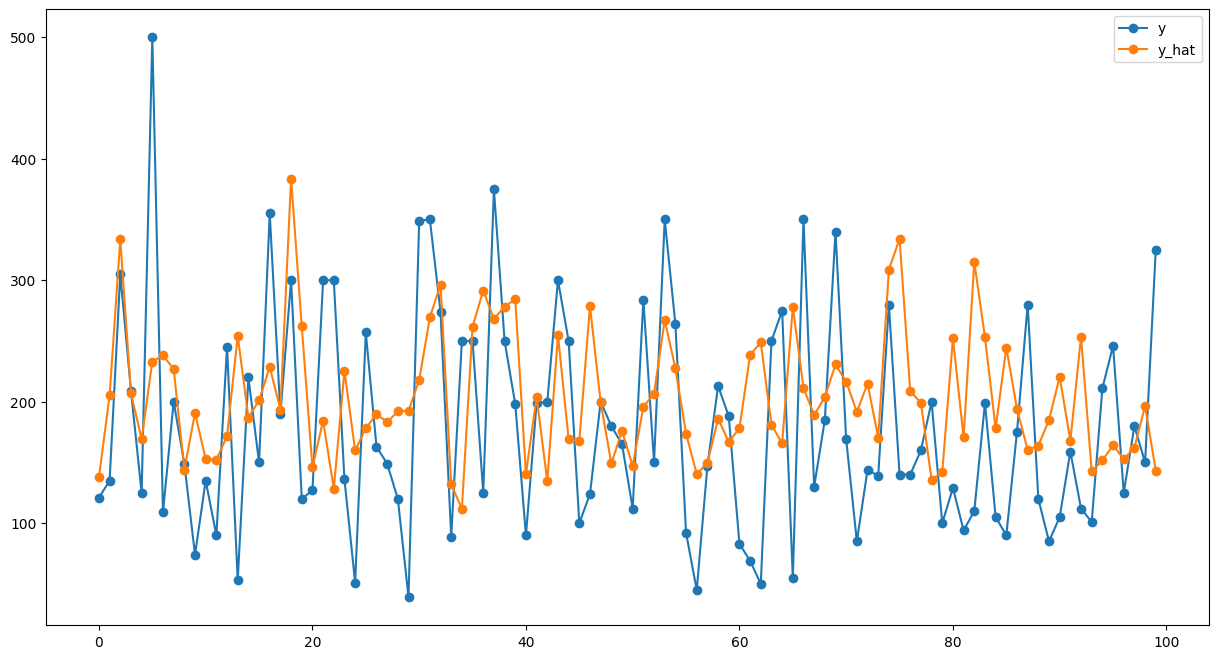

In [14]:
# plot accuracy
plt.figure(figsize=(15, 8))
plt.plot(x_range[:100], y_test[:100], 'o-', label='y')
plt.plot(x_range[:100], y_hat[:100], 'o-', label='y_hat')
plt.legend()
plt.show()

### let's try a different model, a gradient boosting regressor


In [15]:

from sklearn.ensemble import GradientBoostingRegressor

# create the model
gb = GradientBoostingRegressor(n_estimators=20, max_depth=10, random_state=42)

# train the model
gb.fit(X_train, y_train)

# predict
y_hat = gb.predict(X_test)

#  compute metrics
compute_metrics(gb, X_test, y_test)

                       model          mse       rmse        r2        mae
0      RandomForestRegressor  9094.328906  95.364191 -0.048947  75.105715
1  GradientBoostingRegressor  9336.757176  96.626897 -0.076909  75.539092


In [16]:
# create a dataframe with the y and y_hat next to each other
y_hat = y_hat
y_test = y_test
df = pd.DataFrame({'y': y_test, 'y_hat': y_hat})
df.sort_values(by=['y']).head(10)

,y,y_hat
4088,0.0,283.868255
3426,18.0,329.941320
269,30.0,150.124474
3240,34.0,145.515938
1597,35.0,266.116825
3241,38.0,174.243913
5027,39.0,201.148189
5685,40.0,184.215449
3319,41.0,145.274890
3318,41.0,145.274890


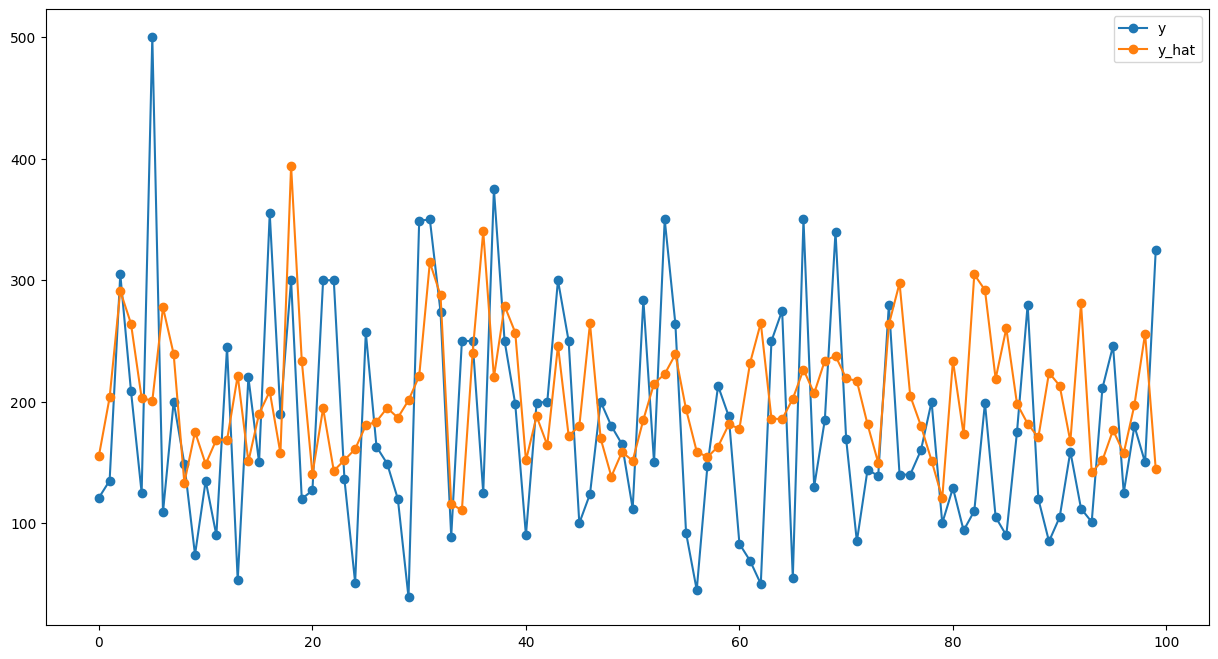

In [17]:
# plot accuracy
plt.figure(figsize=(15, 8))
plt.plot(x_range[:100], y_test[:100], 'o-', label='y')
plt.plot(x_range[:100], y_hat[:100], 'o-', label='y_hat')
plt.legend()
plt.show()

### LGBMRegressor

In [18]:
from lightgbm import LGBMRegressor


# create the model
lgbm = LGBMRegressor(n_estimators=100, max_depth=10, random_state=42)

# train the model
lgbm.fit(X_train, y_train)

# predict
y_hat = lgbm.predict(X_test)

# compute the loss metrics
compute_metrics(lgbm, X_test, y_test)

                       model          mse       rmse        r2        mae
0      RandomForestRegressor  9094.328906  95.364191 -0.048947  75.105715
1  GradientBoostingRegressor  9336.757176  96.626897 -0.076909  75.539092
2              LGBMRegressor  9640.240157  98.184725 -0.111913  76.417029


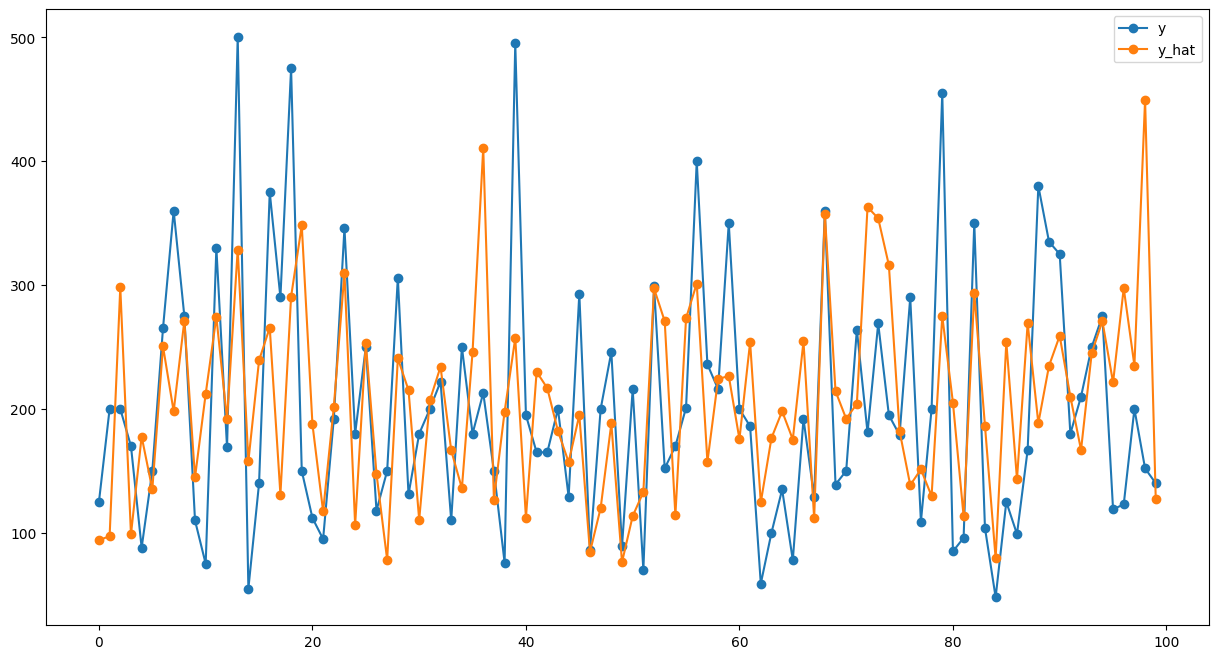

In [19]:
# plot the y and y_hat on two different graphs, plot  the first 100 values, plot in dots and lines
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(x_range[:100], y_test[100:200], 'o-', label='y')
plt.plot(x_range[:100], y_hat[100:200], 'o-', label='y_hat')
plt.legend()


In [20]:
# create a dataframe with the y and y_hat next to each other
y_hat = y_hat
y_test = y_test
df = pd.DataFrame({'y': y_test, 'y_hat': y_hat})
df.sort_values(by=['y']).head(10)

,y,y_hat
4088,0.0,342.300907
3426,18.0,340.120550
269,30.0,144.170739
3240,34.0,114.347917
1597,35.0,310.952933
3241,38.0,120.830457
5027,39.0,203.699839
5685,40.0,149.380689
3319,41.0,82.894693
3318,41.0,87.123045


In [21]:
# Pre-Launch Tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

#  Tensorboard webpage : http://localhost:6006

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | _MLPRegressor | 3.0 K 
----------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mangelini/Develop/UCY/AirBnB_score_prediction/model/models/regressor.py:52: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.mse_loss(y_hat, y)
/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/mangelini/Develop/UCY/AirBnB_score_prediction/model/models/regressor.py:52: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.mse_loss(y_hat, y)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


                       model           mse        rmse        r2        mae
0      RandomForestRegressor   9094.328906   95.364191 -0.048947  75.105715
1  GradientBoostingRegressor   9336.757176   96.626897 -0.076909  75.539092
2              LGBMRegressor   9640.240157   98.184725 -0.111913  76.417029
3               MLPRegressor  15028.746094  122.591789 -0.733428  85.497864


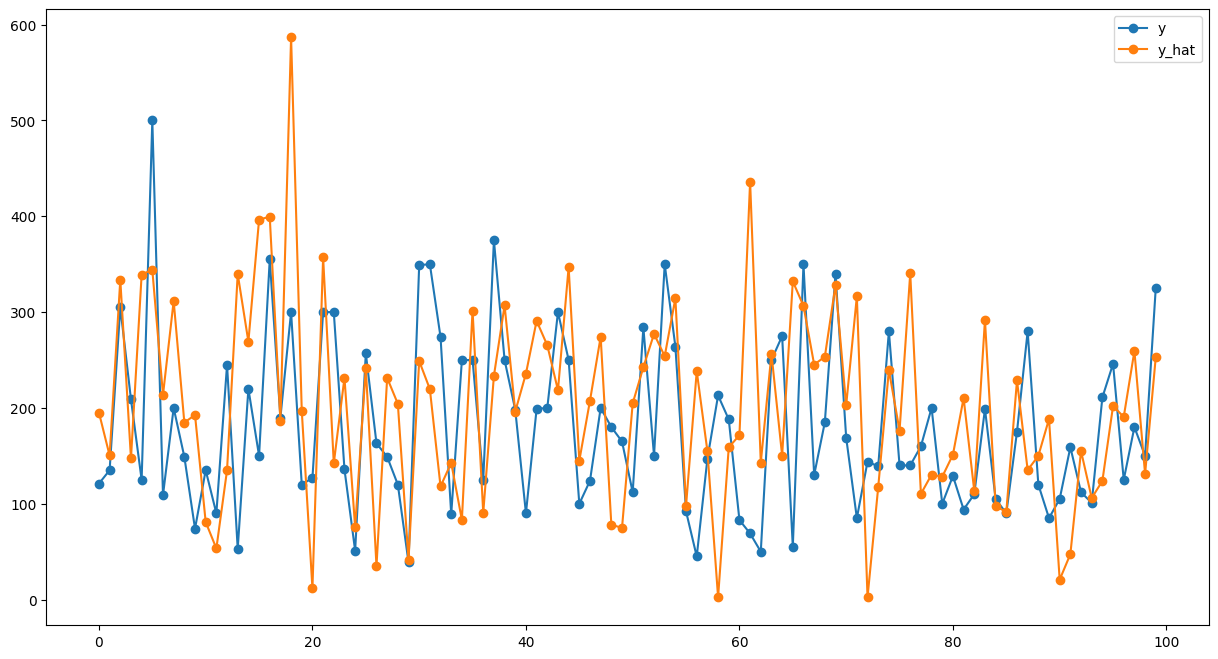

In [22]:

# split data
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train.values, test_size=0.2, random_state=42)

# convert data to float32
X_train = X_train.astype(np.float32)
X_train_1 = X_train_1.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_train_1 = y_train_1.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

# Define the PyTorch DataLoader for training and testing data
train_dataset = TensorDataset(torch.tensor(X_train_1), torch.tensor(y_train_1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test.values))
test_loader = DataLoader(val_dataset, batch_size=32)

# Define the MLPRegressor model
model = MLPRegressor(input_dim=60, hidden_dim=32)

# Define the PyTorch Lightning Trainer
trainer = pl.Trainer(callbacks=[LossAccCallback()],
                    max_epochs=10, accelerator="auto", devices="auto", strategy="auto")
# trainer = pl.Trainer(accelerator="auto", devices="auto", strategy="auto", max_epochs=10)

# Train the model
trainer.fit(model, train_loader, val_loader)
compute_metrics(model, X_test, y_test)


# Plots 
# create a dataframe with the y and y_hat next to each other
y_hat = model(torch.tensor(X_test).float()).detach().numpy()
y_hat = y_hat.reshape(-1)
y_test = y_test
df = pd.DataFrame({'y': y_test, 'y_hat': y_hat})

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(x_range[:100], df.y[:100], 'o-', label='y')
plt.plot(x_range[:100], df.y_hat[:100], 'o-', label='y_hat')
plt.legend()
plt.show()